In [1]:
import dask.array as da
import requests
import geopandas as gpd
import intake
from datetime import datetime
import pandas as pd
import imageio
import matplotlib.pyplot as plt
import numpy as np

import carto2gpd

# Datashader imports
import dask.dataframe as dd
import datashader as ds
import datashader.transfer_functions as tf
from datashader.colors import Greys9, viridis, inferno
from colorcet import fire

Can't load requested DLL: C:\Program Files\GeoDa Software\ogr_FileGDB.dll
126: ?????????

Can't load requested DLL: C:\Program Files\GeoDa Software\ogr_FileGDB.dll
126: ?????????

Can't load requested DLL: C:\Program Files\GeoDa Software\ogr_MSSQLSpatial.dll
126: ?????????

Can't load requested DLL: C:\Program Files\GeoDa Software\ogr_MSSQLSpatial.dll
126: ?????????

Can't load requested DLL: C:\Program Files\GeoDa Software\ogr_OCI.dll
126: ?????????

Can't load requested DLL: C:\Program Files\GeoDa Software\ogr_OCI.dll
126: ?????????

Can't load requested DLL: C:\Program Files\GeoDa Software\ogr_PG.dll
126: ?????????

Can't load requested DLL: C:\Program Files\GeoDa Software\ogr_PG.dll
126: ?????????

Can't load requested DLL: C:\Program Files\GeoDa Software\ogr_FileGDB.dll
126: ?????????

Can't load requested DLL: C:\Program Files\GeoDa Software\ogr_FileGDB.dll
126: ?????????

Can't load requested DLL: C:\Program Files\GeoDa Software\ogr_MSSQLSpatial.dll
126: ?????????

Can't load re

In [2]:
data= pd.read_csv('rtt_summary.csv')
data.tail()

C:\Users\Xiaoyi WU\.conda\envs\py38\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (26,34,39,40) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,objectid,document_id,document_type,display_date,street_address,zip_code,ward,grantors,grantees,cash_consideration,...,street_suffix,street_postdir,reg_map_id,matched_regmap,opa_account_num,legal_remarks,discrepancy,property_count,lat,lng
4233194,12101286,53864104,MORTGAGE,2021-07-30 00:00:00,11031 KNIGHTS RD,19154.0,66.0,MCCAFFERTY MARGARET; MCCAFFERTY MARY A,MORTGAGE ELECTRONIC REGISTRATION SYSTEMS INC; ...,0.0,...,RD,NaN,NaN,153N161179,662218515.0,NaN,NaN,1.0,-74.977488,40.078453
4233195,12101287,53864115,MORTGAGE,2021-07-30 00:00:00,647 FANSHAWE ST,19111.0,35.0,AVILES ORLANDO,MORTGAGE ELECTRONIC REGISTRATION SYSTEMS INC; ...,0.0,...,ST,NaN,NaN,129N100208,353120010.0,NaN,NaN,1.0,-75.089121,40.051236
4233196,12101288,53864117,MORTGAGE,2021-07-30 00:00:00,250 LAURISTON ST UNIT A,19128.0,21.0,PENNINGTON STEVEN,GREENTREE MORTGAGE COMPANY L P; MORTGAGE ELECT...,0.0,...,ST,NaN,NaN,096N090079,213063312.0,NaN,NaN,1.0,-75.206165,40.020100
4233197,12101289,53864118,DEED,2021-05-18 00:00:00,1005 E PHIL ELLENA ST,19150.0,50.0,BARKER DANIEL; RATTIGAN VANESSA,CHERRY BRIAN,265000.0,...,ST,NaN,NaN,152N120284,502358100.0,NaN,no,1.0,-75.171473,40.065724
4233198,12101290,53864119,MORTGAGE,2021-07-30 00:00:00,1005 E PHIL ELLENA ST,19150.0,50.0,CHERRY BRIAN,LOANDEPOTCOM LLC; MORTGAGE ELECTRONIC REGISTRA...,0.0,...,ST,NaN,NaN,152N120284,502358100.0,NaN,NaN,1.0,-75.171473,40.065724


In [3]:
data['month']= pd.to_datetime(data["display_date"]).dt.month
data= data[
    [
        "lat",
        "lng",
        "month",
        "property_count"
    ]
]

In [4]:
city_limits = gpd.read_file(
    "https://opendata.arcgis.com/datasets/405ec3da942d4e20869d4e1449a2be48_0.geojson"
).to_crs(epsg=3857)
limits=city_limits.geometry.total_bounds
limits

array([-8380165.41471603,  4846702.29940936, -8344035.76189658,
        4886006.88680784])

In [5]:
def create_image(df, x_range, y_range, w=6, h=8, cmap=fire):
    """Create an image of taxi dropoffs, returning a Python Imaging Library (PIL) image."""
    
    # Step 1: Create the canvas
    cvs = ds.Canvas(plot_width=w, plot_height=h, x_range=x_range, y_range=y_range)
    
    # Step 2: Aggregate the dropoff positions, coutning number of passengers
    agg = cvs.points(df, 'lat', 'lng',  ds.count('property_count'))
    
    # Step 3: Shade
    img = tf.shade(agg, cmap=cmap, how='eq_hist')
    
    # Set the background
    img = tf.set_background(img, "black")
    
    # NEW: return an PIL image
    return img.to_pil()

In [6]:
def plot_by_month(fig, data, month, x_range, y_range):
    """Plot the dropoffs for particular hour."""
    
    # Trim to the specific hour
    df_this_month = data.loc[data["month"] == month]

    # Create the datashaded image for this hour
    img = create_image(df_this_month, x_range, y_range)

    # Plot the image on a matplotlib axes
    # Use imshow()
    plt.clf()
    ax = fig.gca()
    ax.imshow(img, extent=[x_range[0], x_range[1], y_range[0], y_range[1]])
    
    # Format the axis and figure
    ax.set_aspect("equal")
    ax.set_axis_off()
    fig.subplots_adjust(left=0, right=1, top=1, bottom=0)
    fig.tight_layout()

    # Optional: Add a text label for the hour
    ax.text(
        0.05,
        0.9,
        month,
        color="white",
        fontsize=40,
        ha="left",
        transform=ax.transAxes,
    )

    # Draw the figure and return the image
    # This converts our matplotlib Figure into a format readable by imageio
    fig.canvas.draw()
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype="uint8")
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    return image

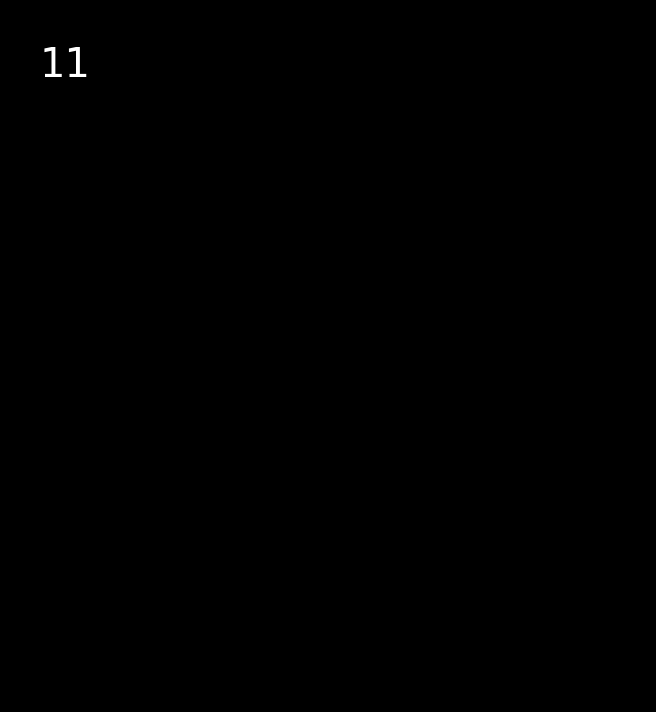

In [7]:
# Create a figure
fig, ax = plt.subplots(figsize=(10,10), facecolor='black')

# Create an image for each hour
imgs = []
for month in range(12):
    
    # Plot the datashaded image for this specific hour
    img = plot_by_month(fig, data, month, x_range=[limits[0],limits[2]], y_range=[limits[1],limits[3]])
    imgs.append(img)
    
# Combing the images for each hour into a single GIF
imageio.mimsave('month.gif', imgs, fps=1);